In [1]:
import gym
import torch

from src.Learner.AWAC import AWAC
from src.Learner.DQN import DQN
from src.Learner.Random import DiscreteRandomAgent
from src.nn.MLP import MLP
from src.utils.memory import ReplayMemory
from src.utils.train_utils import prepare_training_inputs

import matplotlib.pyplot as plt

In [2]:
gamma = 0.9
memory_size = 500000

In [3]:
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

In [72]:
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

## Prepare offline data

In [73]:
use_expert = True
if use_expert:    
    qnet = MLP(4, 2, num_neurons=[128])
    qnet_target = MLP(4, 2, num_neurons=[128])
    dqn = DQN(4, 1, qnet=qnet,qnet_target=qnet_target, lr=1e-4, gamma=gamma, epsilon=1.0)
    state_dict = torch.load('dqn_agent.pt')
    
    # make trained agent slightly dumb
    # to simulate the realistic scenario where we don't have 'perfect' policy
    # but good enough policy.
    
    state_dict['epsilon'] = dqn.epsilon * .4 
    dqn.load_state_dict(state_dict)    
    offline_agent = dqn
    offline_budget = 50
else:
    offline_agent = DiscreteRandomAgent(2)
    offline_budget = 300

online_budget = offline_budget

In [74]:
cum_rs = []
for n_epi in range(offline_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = offline_agent.get_action(s)
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            cum_rs.append(cum_r)
            break

(array([0.01954023, 0.01494253, 0.01034483, 0.00344828, 0.0045977 ,
        0.        , 0.00114943, 0.00114943, 0.        , 0.00229885]),
 array([ 12. ,  29.4,  46.8,  64.2,  81.6,  99. , 116.4, 133.8, 151.2,
        168.6, 186. ]),
 <BarContainer object of 10 artists>)

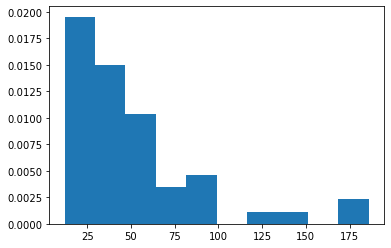

In [75]:
plt.hist(cum_rs, density=True, label='expert')

## AWAC offline train + online off-policy train

* offline training

In [8]:
%%time
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]
Wall time: 1min 30s


AWAC(
  (critic): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (critic_target): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (actor): MLP(
    (hidden_act): ReLU()
    (out_act): Identity()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2,

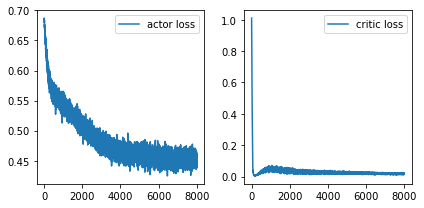

In [9]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
fig.tight_layout()

* check offline perf

In [10]:
%%time
num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break

Wall time: 21.5 s


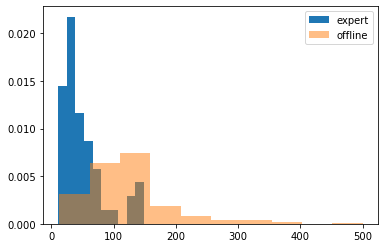

In [11]:
plt.hist(cum_rs, density=True, label='expert')
plt.hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
plt.legend()

* Online fine tuning
* 데이터를 replay memory에 추가해가며 off-policy 방식으로 트레이닝

In [12]:
agent.to('cpu')

AWAC(
  (critic): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (critic_target): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (actor): MLP(
    (hidden_act): ReLU()
    (out_act): Identity()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2,

In [13]:
# false로 설정하여 메모리에 계속 추가됨
refresh_memory = False
if refresh_memory:
    memory.reset()

In [14]:
%%time
# 메모리에 online data 수집하는 과정
online_budget = 600
online_awac_cum_rs = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_done)
        actor_loss = agent.update_actor(_s,_a)
        critic_losses.append(critic_loss.detach())
        actor_losses.append(actor_loss.detach())
        agent.to('cpu')

Wall time: 50 s


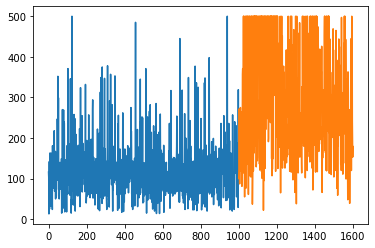

In [15]:
plt.plot(range(len(awac_cum_rs)), awac_cum_rs)
plt.plot(range(len(awac_cum_rs), 
               len(awac_cum_rs + online_awac_cum_rs)), 
         online_awac_cum_rs)

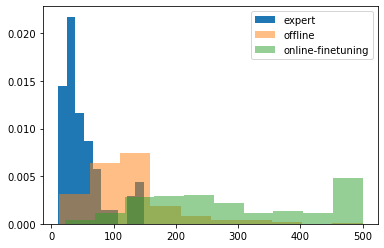

In [16]:
# 성능은 좋음
plt.hist(cum_rs, density=True, label='expert')
plt.hist(awac_cum_rs, alpha=0.5, density=True, label='offline')
plt.hist(online_awac_cum_rs, alpha=0.5, density=True, label='online-finetuning')
plt.legend()

## DQN _ offline train + online finetune

* offline training

In [109]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

#오프라인데이터셋에 대해 탐색한 explore을 저장하지는 않기때문에 0으로 설정하고 online tuning할때 올려서 epslilon 설정
epsilon = float(0.0)
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

In [110]:
%%time
batch_size = 1024
n_updates = 1000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_dqn_agent.to(fit_device)
losses = []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    loss = new_dqn_agent.update(s,a,r,ns,done)
    losses.append(loss.detach())
    
    
          
new_dqn_agent.to('cpu')

fitting [0] / [1000]
Wall time: 9.26 s


DQN(
  (state_dim): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (qnet): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (qnet_target): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bi

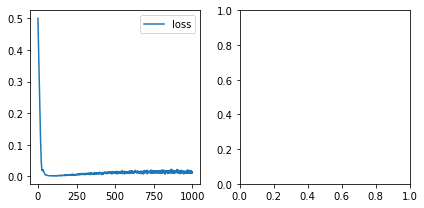

In [111]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses, label='loss')
axes[0].legend()
fig.tight_layout()

* check offline perf

In [112]:
%%time
num_runs = 500
new_dqn_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    # 몇초 버텼나
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        # a = int(new_dqn_agent.get_action(s).squeeze())
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            new_dqn_cum_rs.append(cum_r)
            break

Wall time: 9.98 s


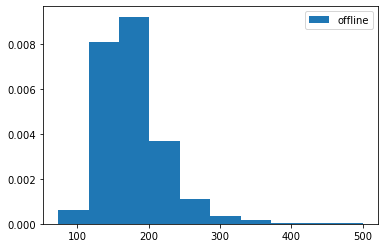

In [113]:
plt.hist(new_dqn_cum_rs, density=True, label='offline')
plt.legend()

* Online fine tuning
* 데이터를 replay memory에 추가해가며 off-policy 방식으로 트레이닝

In [114]:
new_dqn_agent.to('cpu')

DQN(
  (state_dim): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (qnet): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (qnet_target): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bi

In [115]:
# false로 설정하여 메모리에 계속 추가됨
refresh_memory = False
if refresh_memory:
    memory.reset()

In [116]:
%%time
# 메모리에 online data 수집하는 과정
online_budget = 2000
online_dqn_cum_rs = []
new_dqn_agent.epsilon = new_dqn_agent.epsilon+0.8
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_dqn_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        new_dqn_agent.to(fit_device)
        loss = new_dqn_agent.update(_s,_a,_r,_ns,_done)
        
        losses.append(loss.detach())
        
        new_dqn_agent.to('cpu')
        # ep 점점 감소하는 방식
        new_dqn_agent.epsilon = new_dqn_agent.epsilon*(online_budget-n_epi)/online_budget

Wall time: 1min 6s


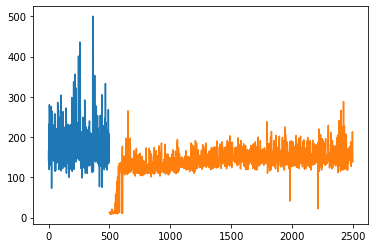

In [117]:
plt.plot(range(len(new_dqn_cum_rs)), new_dqn_cum_rs)
plt.plot(range(len(new_dqn_cum_rs), 
               len(new_dqn_cum_rs + online_dqn_cum_rs)), 
         online_dqn_cum_rs)

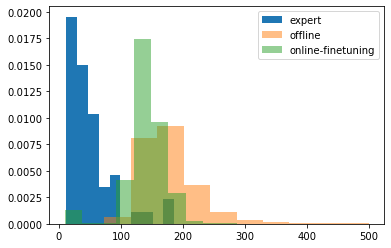

In [118]:
plt.hist(cum_rs, density=True, label='expert')
plt.hist(new_dqn_cum_rs, alpha=0.5, density=True, label='offline')
plt.hist(online_dqn_cum_rs, alpha=0.5, density=True, label='online-finetuning')
plt.legend()

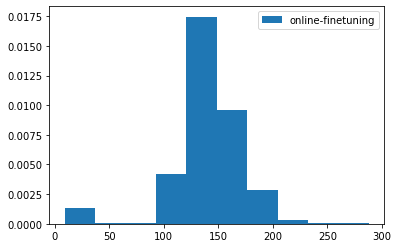

In [119]:
plt.hist(online_dqn_cum_rs, density=True, label='online-finetuning')
plt.legend()

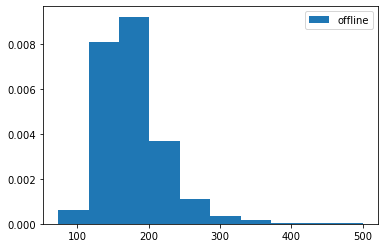

In [120]:
plt.hist(new_dqn_cum_rs,  density=True, label='offline')
plt.legend()

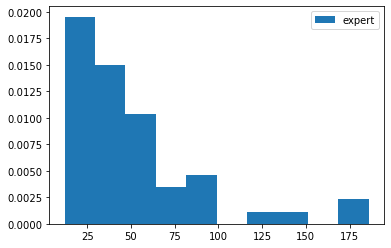

In [121]:
plt.hist(cum_rs, density=True, label='expert')
plt.legend()

## DQN online off-policy train

In [24]:
# qnet = MLP(4, 2, 
#            num_neurons=[128,128], 
#            out_act='ReLU')
# state =4차원 action 2차원
memory_size = 500000
memory_online_dqn = ReplayMemory(memory_size)
qnet = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')
qnet_target = MLP(4, 2, num_neurons=[128,128],out_act='ReLU')

epsilon = 0.8
gamma = 0.9
lr = 0.001
action_dim = 1

# q_net target을 어찌설정할지 모르겠음
online_new_dqn_agent = DQN(state_dim=qnet,action_dim=action_dim,qnet=qnet,qnet_target=qnet_target,lr=lr,epsilon=epsilon,gamma=gamma,)

In [25]:
%%time
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
online_new_dqn_agent.to(fit_device)

Wall time: 1 ms


DQN(
  (state_dim): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (qnet): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (qnet_target): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bi

In [26]:
# false로 설정하여 메모리에 계속 추가됨
refresh_memory = False
if refresh_memory:
    memory_online_dqn.reset()

In [27]:
%%time
# 메모리에 online data 수집하는 과정
online_budget = 5000
batch_size = 1000
online_dqn_cum_rs = []
dqn_online_losses = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = online_new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory_online_dqn.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_dqn_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory_online_dqn) >= batch_size:
        if n_epi%batch_size ==0:
            print("fitting [{}] / [{}]".format(n_epi, online_budget))
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory_online_dqn.sample(batch_size)
        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        online_new_dqn_agent.to(fit_device)
        loss = online_new_dqn_agent.update(_s,_a,_r,_ns,_done)
        # ep 점점 감소하는 방식
        online_new_dqn_agent.epsilon = online_new_dqn_agent.epsilon*(online_budget-n_epi)/online_budget
        dqn_online_losses.append(loss.detach())
        
        online_new_dqn_agent.to('cpu')

fitting [1000] / [5000]
fitting [2000] / [5000]
fitting [3000] / [5000]
fitting [4000] / [5000]
Wall time: 3min 57s


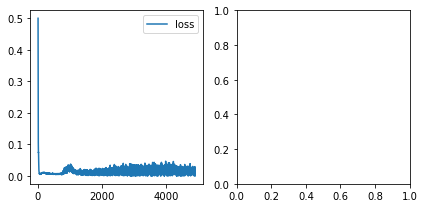

In [28]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(dqn_online_losses, label='loss')
axes[0].legend()
fig.tight_layout()

In [29]:
only_online_dqn_cum_rs = []
test = 500
for n_epi in range(test):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = online_new_dqn_agent.get_action(s)
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory_online_dqn.push(experience)

        s = ns
        cum_r += 1
        if done:
            only_online_dqn_cum_rs.append(cum_r)
            break

(array([0.00282051, 0.00564103, 0.01410256, 0.01897436, 0.02358974,
        0.02666667, 0.01897436, 0.00974359, 0.00666667, 0.00102564]),
 array([288. , 295.8, 303.6, 311.4, 319.2, 327. , 334.8, 342.6, 350.4,
        358.2, 366. ]),
 <BarContainer object of 10 artists>)

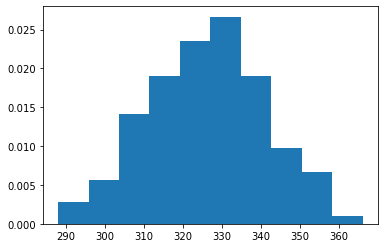

In [30]:
plt.hist(only_online_dqn_cum_rs, density=True, label='only_online_dqn')

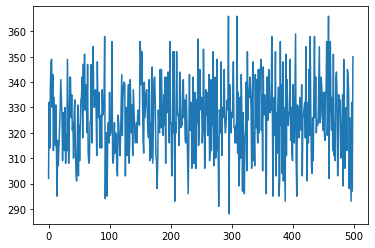

In [31]:
plt.plot(range(len(only_online_dqn_cum_rs)), only_online_dqn_cum_rs)

## awac only online train

In [2]:
gamma = 0.9
memory_size = 500000

In [3]:
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

In [4]:
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

In [5]:
%%time
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent.to(fit_device)

Wall time: 1 ms


AWAC(
  (critic): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (critic_target): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (actor): MLP(
    (hidden_act): ReLU()
    (out_act): Identity()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2,

In [6]:
# false로 설정하여 메모리에 계속 추가됨
refresh_memory = False
if refresh_memory:
    memory_online_dqn.reset()

In [7]:
%%time
# 메모리에 online data 수집하는 과정
online_budget = 5000
batch_size = 1000
online_awac_cum_rs = []

online_critic_losses = []
online_actor_losses = []
for n_epi in range(online_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if done:
            online_awac_cum_rs.append(cum_r)
            break
    
    # 데이터를 수집한 후 모델 업데이트
    if len(memory) >= batch_size:
        if n_epi%batch_size ==0:
            print("fitting [{}] / [{}]".format(n_epi, online_budget))
        
        #전체데이터를 사용하는 것이 아니라 샘플링을 통해 사용(offline data도 포함되어 있는 상태)
        sampled_exps = memory.sample(batch_size)
        # s, a, r, ns, done = prepare_training_inputs(sampled_exps,device=fit_device)  

        # critic_loss = agent.update_critic(s,a,r,ns,done)
        # actor_loss = agent.update_actor(s,a)

        _s, _a, _r, _ns, _done = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_done)
        actor_loss = agent.update_actor(_s,_a)
        
        online_critic_losses.append(critic_loss.detach())
        online_actor_losses.append(actor_loss.detach())   


        

        agent.to('cpu')

C:\Users\Go\miniconda3\envs\pro1\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  del sys.path[0]


fitting [1000] / [5000]
fitting [2000] / [5000]
fitting [3000] / [5000]
fitting [4000] / [5000]
Wall time: 3min 22s


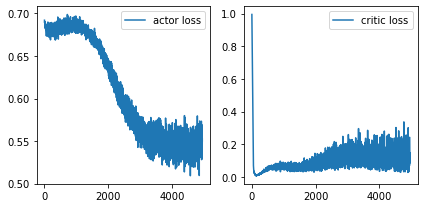

In [8]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(online_actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(online_critic_losses, label='critic loss')
axes[1].legend()
fig.tight_layout()

In [9]:
only_online_awac_cum_rs = []
test = 500
for n_epi in range(test):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            only_online_awac_cum_rs.append(cum_r)
            break

(array([0.00053608, 0.00065979, 0.00160825, 0.00713402, 0.0062268 ,
        0.00296907, 0.00065979, 0.00053608, 0.00016495, 0.00012371]),
 array([ 15. ,  63.5, 112. , 160.5, 209. , 257.5, 306. , 354.5, 403. ,
        451.5, 500. ]),
 <BarContainer object of 10 artists>)

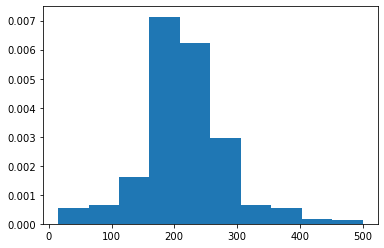

In [10]:
plt.hist(only_online_awac_cum_rs, density=True, label='only_online_awac')

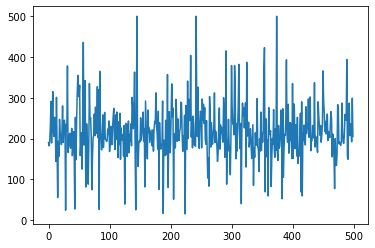

In [11]:
plt.plot(range(len(only_online_awac_cum_rs)), only_online_awac_cum_rs)